#**ML-POWERED OBJECTIFICATION AND SUBJECTIFICATION OF TEXT**
Kieran Mendoza, Wang Hengyue

# Introduction
Often, the biases and the judgements of journalists get in the way of the facts and the truth. This project aims to first detect whether a piece of text is subjective or objective, then reframe it to eliminate the prejudices and be more factual. 

This project includes a Supervised model using Naïve Bayes to detect whether the author sentiment is positive or negative. Extending from this, it aims to quantify the author sentiment in the text.

However, the hallmark of this project is the development of a model that performs objectivication of the text, and vice versa. We aim to use [this](https://arxiv.org/abs/1809.04556) as a framework to achieve this.

**Domain: Media, Literature**

**Subject Area: Supervised Learning, Unsupervised Learning, Natural Language Processing**

## Objectives
* Detection of author stance
* Detection of subjective or objective text
* Manipulation of text from being subjective to objective and vice-versa.

## Target Audience
*   Fake news detection agencies - a highly subjective article is likely to contain some fallacious statements
*   Media companies - a quick method of turning an otherwise boring, dull chain of facts into a more engaging story
*  English teachers - aid for grading essays to determine if the student is writing subjectively or objectively

## Target Outcome and Benefits
1. Catering to the preference of different readers - some readers prefer the facts presented neatly and clearly while others may want more personal voice
2. Formation of an engaging story from a “skeleton” of facts collected, allowing for a “quick story”.






# Data Collection and Data Cleaning
We import data from a GitHub repository due to the sheer size of the dataset. The dataset can be found under resources, but can also be found [here](http://www.cs.cornell.edu/people/pabo/movie-review-data/). It contains 2004-2005 Rotten Tomatoes movie review data, as well as iMDB reviews and plot reports.

In [1]:
!git clone https://github.com/Kimame04/nlp-text-subjectivity-conversion.git

Cloning into 'nlp-text-subjectivity-conversion'...
remote: Enumerating objects: 1772, done.
remote: Counting objects: 100% (1772/1772), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 1772 (delta 1652), reused 1709 (delta 1626), pack-reused 0
Receiving objects: 100% (1772/1772), 11.84 MiB | 8.86 MiB/s, done.
Resolving deltas: 100% (1652/1652), done.


In [2]:
#imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import re
import pickle
import random

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

Annoyingly, plenty of the data has custom file extensions, which means that they must first be converted to their original file extensions (.txt) before any operations can be conducted on it.

In the end, I combined the reviews of each reviewer into a dataframe, which is then combined into a 'complete collection' dataset, for further analysis.

Each dataframe has the following attributes:

- Review content
- Rating 
- ID 
- Three-class label
- Four-class label

In [4]:
path = '/content/nlp-text-subjectivity-conversion/data' #if running on Google Colab
# path = 'nlp-text-subjectivity-conversion/data' if running on jupyter-notebook

def readTxt(fileName):
  fileObj = open(fileName,'r',encoding="windows-1252")
  words = fileObj.read().splitlines()
  fileObj.close()
  return words

def read_files(path):
  all_series = []
  for folder in os.listdir(path):
    subpath = path+'/'+folder
    if os.path.isdir(subpath):
      for filename in os.listdir(subpath):
        filepath = os.path.join(subpath,filename)
        if (filepath.count('.txt')<1):
          new_filepath = filepath+'.txt'
          os.rename(filepath,new_filepath)
          series = pd.Series(readTxt(new_filepath))
          series.name = filename
          all_series.append(series)
  df = pd.concat(all_series,axis=1)
  return df

df = read_files(path)
df.head()

,rating.James+Berardinelli,subj.James+Berardinelli,id.James+Berardinelli,label.3class.James+Berardinelli,label.4class.James+Berardinelli,rt-polarity.neg,rt-polarity.pos,subjdata.README.1.0,plot.tok.gt9.5000,quote.tok.gt9.5000,rating.Steve+Rhodes,id.Steve+Rhodes,subj.Steve+Rhodes,label.4class.Steve+Rhodes,label.3class.Steve+Rhodes,rating.Dennis+Schwartz,label.4class.Dennis+Schwartz,id.Dennis+Schwartz,subj.Dennis+Schwartz,label.3class.Dennis+Schwartz,id.Scott+Renshaw,subj.Scott+Renshaw,label.4class.Scott+Renshaw,rating.Scott+Renshaw,label.3class.Scott+Renshaw
0,0.05,i didn't expect ghost in the machine to be thi...,2321,0,0,"simplistic , silly and tedious .",the rock is destined to be the 21st century's ...,,the movie begins in the past where a young boy...,"smart and alert , thirteen conversations about...",0.1,11790,this bit of lame physical humor is typical of ...,0,0,0.1,0,29420,"in my opinion , a movie reviewer's most import...",0,11961,i'm guessing -- and from the available evidenc...,0,0,0
1,0.05,"admittedly , with a title like the mangler , y...",3337,0,0,"it's so laddish and juvenile , only teenage bo...","the gorgeously elaborate continuation of "" the...",=======,emerging from the human psyche and showing cha...,"color , musical bounce and warm seas lapping o...",0.1,17628,some comedies are not funny no matter how hard...,0,0,0.2,0,17219,"you can watch this movie , that is based on a ...",0,13915,"there's bad buzz , and then there's the the ba...",0,0,0
2,0.05,"cast : christopher lambert , natasha henstridg...",6511,0,0,exploitative and largely devoid of the depth o...,effective but too-tepid biopic,,spurning her mother's insistence that she get ...,it is not a mass-market entertainment but an u...,0.1,18971,you'll check your watch frequently waiting for...,0,0,0.2,0,18406,"this is asking a lot to believe , and though i...",0,2790,director : richard rush . director richard rus...,0,0,0
3,0.05,"inevitably , someone is going to ask me why i ...",6912,0,0,[garbus] discards the potential for pathologic...,if you sometimes like to go to the movies to h...,Introduction,amitabh can't believe the board of directors a...,a light-hearted french film about the spiritua...,0.1,28767,"freddy got fingered , written and directed by ...",0,0,0.2,0,18648,no heroes and no story are the main attributes...,0,3285,screenplay : johnny brennan & kamal ahmed and ...,0,0,0
4,0.09,ernest : the one-joke concept that refuses to ...,2240,0,0,a visually flashy but narratively opaque and e...,"emerges as something rare , an issue movie tha...",,"she , among others excentricities , talks to a...",my wife is an actress has its moments in looki...,0.1,3579,it is a mess of a movie . if you are so advent...,0,0,0.2,0,20021,"this is not an art movie , yet i saw it an art...",0,10264,screenplay : tim burns & tom stern and anthony...,0,0.1,0


# Objectivity Detection

We explore **two** methods to detect objectivity, and then decide which method is more effective. Both use the same Supervised Learning methods and use the Naïve Bayes algorithm. But the difference is the approach taken with the dataset.

The first is to distinguish sentences with a 'positive' sentiment from a 'negative' one. If the algorithm is unable to firmly decide between the two, we assume the text to be objective. 

The second (and more conventional and direct method) is to actually train the data on subjective and objective text, and predict objectivity.

In [5]:
def clean_dataframe(df):
  df = df.dropna()
  df = pd.concat((df.iloc[:,0],df.iloc[:,1]),axis=0).reset_index(drop=True)
  punctuation_signs = list("?.:;,!")
  for punct_sign in punctuation_signs:
      df = df.str.replace(punct_sign, '')

  lemmatized_text_list = []

  wordnet_lemmatizer = WordNetLemmatizer()

  for row in range(0, len(df)):
    lemmatized_list = []
    text = df.loc[row]
    text_words = text.split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)
    lemmatized_text_list.append(lemmatized_text)

  df = pd.Series(lemmatized_text_list)

  df = df.str.replace("'s","")
  stop_words = list(stopwords.words('english'))

  for stop_word in stop_words:
      regex_stopword = r"\b" + stop_word + r"\b"
      df = df.str.replace(regex_stopword, '')
  df = pd.DataFrame(df,columns=['content'])
  return df

def train_predict(series_x,series_y):
  x_train, x_test, y_train, y_test = train_test_split(series_x, 
                                                      series_y, 
                                                      test_size=0.3)
  model = make_pipeline(TfidfVectorizer(), MultinomialNB())
  model.fit(x_train, y_train)
  predicted_categories = model.predict(x_test)
  mat = confusion_matrix(y_test, predicted_categories)
  sns.heatmap(mat.T,annot=True, fmt = "d")
  plt.xlabel("true labels")
  plt.ylabel("predicted label")
  plt.show()
  return model, accuracy_score(y_test, predicted_categories), x_train, x_test, y_train, y_test

def convert_txt(series,name):
  series.to_csv(name + '.txt', sep='\n', index=False)

def write_to_txt(x_train, x_test, y_train, y_test, name1, name2, name3, name4, name5, name6, df):
  train_df = pd.concat((x_train,y_train),axis=1)
  neg_train = train_df.loc[train_df.code==0].squeeze().iloc[:,0]
  pos_train = train_df.loc[train_df.code==1].squeeze().iloc[:,0]
  convert_txt(neg_train,name1)
  convert_txt(pos_train,name2)

  test_df = pd.concat((x_test,y_test),axis=1)
  neg_test = test_df.loc[test_df.code==0].iloc[:,0]
  pos_test = test_df.loc[test_df.code==1].iloc[:,0]
  convert_txt(neg_test,name3)
  convert_txt(pos_test,name4)

  convert_txt(df.loc[df.code==0].iloc[:,0],name5)
  convert_txt(df.loc[df.code==1].iloc[:,0],name6)

## Approach 1 - Objectiveness detection via sentiment

Now, we format the positive and negative reviews. That is, we lemmatize the text, remove the punctuation signs and remove the stop words in the dataset. This prevents instances where the same root word is actually counted differently.

We quantify the author stance by mapping the stances. Negative stance is labeled 0, while positive stance is labeled 1.

In [6]:
polarityDf = df[['rt-polarity.neg','rt-polarity.pos']].copy()

polarityDf = clean_dataframe(polarityDf)
polarityDf['stance'] = 'negative'
polarityDf['stance'][5331:] = 'positive'

stance_codes = {
    'negative': 0,
    'positive': 1,
}

polarityDf['code'] = polarityDf['stance']
polarityDf = polarityDf.replace({'code':stance_codes})
polarityDf.head()

,content,stance,code
0,simplistic silly tedious,negative,0
1,laddish juvenile teenage boys could possi...,negative,0
2,exploitative largely devoid depth sophisti...,negative,0
3,[garbus] discard potential pathological stud...,negative,0
4,visually flashy narratively opaque emotiona...,negative,0


We then train the dataset with the content and the stance codes. We use a multinomial Naïve Bayes algorithm to train it, and we plot a confusion matrix showing the performance of our model. 

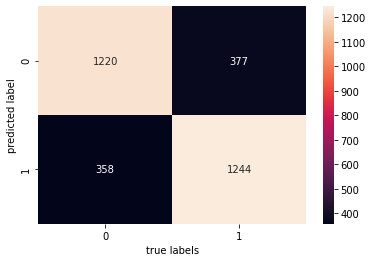

0.7702407002188184

In [7]:
result = train_predict(polarityDf['content'],polarityDf['code'])
model = result[0]
write_to_txt(result[2],result[3],result[4],result[5],'train_neg_content','train_pos_content',
             'test_neg_code','test_pos_code','all_neg','all_pos',polarityDf)
result[1]

Here is a sample prediction of a positive sentiment. What is returned is the probability of the text having a negative stance, or having a positive stance.

In [8]:
pos = model.predict_proba(['engaging and fun, amogus is the perfect game for all!'])
neg = model.predict_proba(['this game is just unplayable. it\'s ugly, obsolete and completely unoriginal'])
pos,neg

(array([[0.2443404, 0.7556596]]), array([[0.77622993, 0.22377007]]))

As seen in the below examples, more objective statements have more balanced scores, and can be used as a distinguishing measure.

In [9]:
obj_pos = model.predict_proba(['the game has been awarded the editor\'s choice award'])
obj_neg = model.predict_proba(['people have complained that the game is not up to par'])
obj_pos, obj_neg

(array([[0.40510711, 0.59489289]]), array([[0.59806597, 0.40193403]]))

## Approach 2 - Direct objectiveness detection
Our second approach is to use subjective and objective statements, and compare the accuracy of the two approaches. The plot sumamries are objective, while the quotes weres subjective. In the original dataset, there are 5000 of each type of data.

Objective is labeled 0, while subjective is labeled 1.

In [10]:
subjectivityDf = df[['plot.tok.gt9.5000','quote.tok.gt9.5000']].copy()
subjectivityDf = clean_dataframe(subjectivityDf)
subjectivityDf['voice'] = 'subjective'
subjectivityDf.iloc[:5000,1] = 'objective'
voice_codes = {
    'subjective': 0,
    'objective': 1,
}

subjectivityDf['code'] = subjectivityDf['voice']
subjectivityDf = subjectivityDf.replace({'code':voice_codes})
subjectivityDf.head()

,content,voice,code
0,movie begin past young boy name sam attem...,objective,1
1,emerge human psyche show characteristics a...,objective,1
2,spurn mother insistence get life mary ...,objective,1
3,amitabh ' believe board directors mind fi...,objective,1
4,among others excentricities talk small ro...,objective,1


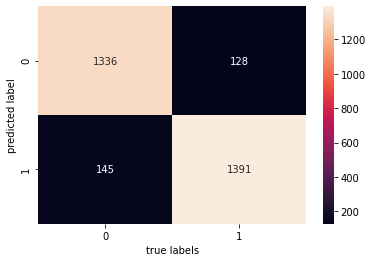

0.909

In [11]:
result = train_predict(subjectivityDf['content'],subjectivityDf['code'])
model_direct = result[0]
write_to_txt(result[2],result[3],result[4],result[5],'train_sub_content','train_obj_content',
             'test_sub_code','test_obj_code','all_sub','all_obj',subjectivityDf)
result[1]

In [12]:
pos = model_direct.predict_proba(['engaging and fun, amogus is the perfect game for all!'])
neg = model_direct.predict_proba(['this game is just unplayable. it\'s ugly, obsolete and completely unoriginal'])
pos,neg

(array([[0.64980673, 0.35019327]]), array([[0.74653838, 0.25346162]]))

In [13]:
obj_pos = model_direct.predict_proba(['the game has been awarded the editor\'s choice award'])
obj_neg = model_direct.predict_proba(['people have complained that the game is not up to par'])
obj_pos, obj_neg

(array([[0.34098623, 0.65901377]]), array([[0.5448116, 0.4551884]]))

For easy retrieval of data in a short amount of time for the UI, we use `pickle` to store and load the data. Here, we save the data as a .sav file.

In [14]:
filename = 'objectivity-detection-sentiment.sav'
pickle.dump(model, open(filename, 'wb'))

filename2 = 'objectivity-detection-direct.sav'
pickle.dump(model_direct, open(filename2, 'wb'))

The code below retrieves the model from the .sav file.

In [15]:
retrieved_model = pickle.load(open(filename,'rb'))

retrieved_model_direct = pickle.load(open(filename2,'rb'))

# use retrieved_model.predict(x_test) to get the absolute classification results
# use retrieved model.predict_proba(x_test) to get the probability of the classification result

# Objectification and Subjecification: The Naïve Way
This approach simply takes the most subjective/objective synonym of the word and plugs it into the sentence. Obviously this would lead to severe amount of sentence incoherence and content changes, since the system is unable to understand the 'context'.

In [16]:
word_list = words.words()
scores = []
samples = random.sample(word_list,5000)
for word in samples:
  score = model_direct.predict_proba([word])[0][0]
  scores.append((score,word))
scores.sort(reverse=True)

In [17]:
scores[-10:]  

[(0.26239099776769864, 'south'),
 (0.24641579894754115, 'chapman'),
 (0.24188906020452022, 'audition'),
 (0.2380223383939419, 'back'),
 (0.22599885977769105, 'gold'),
 (0.22286066131217422, 'devil'),
 (0.20762827996384037, 'begin'),
 (0.19571734144252548, 'drink'),
 (0.19559136446755437, 'pursuit'),
 (0.08861744069943828, 'kill')]

In [18]:
def getTopWords(type):
  scores = []
  samples = random.sample(all_adjectives,5000)
  for word in samples:
    converted = word.name().split('.')[0]
    score = model_direct.predict_proba([converted])[0][0]
    scores.append((score,converted))
  scores.sort(reverse=True)
  return scores

In [19]:
all_adjectives = [synset for synset in list(wordnet.all_synsets('a'))]
all_adverbs = [synset for synset in list(wordnet.all_synsets('r'))]
getTopWords(all_adverbs)[:10]

[(0.8845325741140916, 'excellent'),
 (0.8766278379240549, 'enjoyable'),
 (0.8632093927143983, 'dull'),
 (0.8632093927143983, 'dull'),
 (0.8632093927143983, 'dull'),
 (0.8632093927143983, 'dull'),
 (0.860290471667273, 'less-traveled'),
 (0.860290471667273, 'less'),
 (0.8510509716345213, 'slow'),
 (0.8510509716345213, 'slow')]

# NLP 

# Resources

**Papers**

https://ojs.aaai.org/index.php/AAAI/article/view/6433

https://arxiv.org/abs/1809.04556
https://papers.nips.cc/paper/2017/file/2d2c8394e31101a261abf1784302bf75-Paper.pdf

**Dataset** 

http://www.cs.cornell.edu/people/pabo/movie-review-data/